## Imports and Functions

In [1]:
%pip install ipympl


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Run this in its own cell BEFORE plotting
from IPython import get_ipython

def enable_notebook_interaction():
    ip = get_ipython()
    if not ip:
        print("Not running inside IPython/Jupyter.")
        return
    try:
        import ipympl  # needs: pip install ipympl
        ip.run_line_magic("matplotlib", "widget")
        print("✅ Using %matplotlib widget (ipympl). Click/drag now works.")
    except ImportError:
        ip.run_line_magic("matplotlib", "notebook")
        print("⚠️ ipympl not installed. Using %matplotlib notebook (less robust).\n"
              "Install ipympl for best results: pip install ipympl")

enable_notebook_interaction()


✅ Using %matplotlib widget (ipympl). Click/drag now works.


In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

# =========================
# Helpers / I/O
# =========================

def load_mat_file(file_path):
    """
    Load a MATLAB file, handling both v7.3 (HDF5) and earlier formats.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return None
    try:
        data = loadmat(file_path)
        print(f"Loaded non-v7.3 file: {file_path}")
        return data
    except NotImplementedError:
        try:
            with h5py.File(file_path, 'r') as f:
                print(f"Loaded v7.3 file: {file_path}")
                return {key: f[key][:] for key in f.keys() if not key.startswith('__')}
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return None

def calculate_rms(signal, window_size=100):
    """
    Calculate 
      with a sliding window for a 1D signal.
    """
    signal = np.asarray(signal, dtype=float).flatten()
    signal = signal[np.isfinite(signal)]
    if len(signal) == 0:
        return np.array([])

    pad = window_size // 2
    padded = np.pad(signal, pad, mode='edge')
    rms = np.zeros(len(signal), dtype=float)

    for i in range(len(signal)):
        window = padded[i:i+window_size]
        rms[i] = np.sqrt(np.mean(window**2))
    return rms

def explore_mat_structure(file_path):
    """
    Quick exploration of what's in the MAT file.
    """
    data = load_mat_file(file_path)
    if data is None:
        return None

    print(f"\nStructure of {os.path.basename(file_path)}:")
    print("-" * 40)
    for key, value in data.items():
        if not key.startswith('__'):
            if isinstance(value, np.ndarray):
                print(f"{key}: {value.shape} - {value.dtype}")
                if value.size < 20:
                    print(f"  Values: {value.flatten()}")
                else:
                    flat_val = value.flatten()
                    print(f"  Sample values: {flat_val[:5]}...")
                    print(f"  Min: {np.min(flat_val)}, Max: {np.max(flat_val)}")
            else:
                print(f"{key}: {type(value)}")
    return data

# =========================
# EMG object->matrix converter
# =========================

def object_emg_to_matrix(obj_arr):
    """
    Convert an object/cell array of EMG channels (e.g., shape (8,2)) into a 2D float array (C, T).
    Each element is expected to be a 1D array-like time series. Channels are aligned to the shortest length.
    Returns shape (C, T), where C = number of non-empty cells.
    """
    if not isinstance(obj_arr, np.ndarray) or obj_arr.dtype != object:
        raise ValueError("object_emg_to_matrix expects a numpy object array (MATLAB cell-array-like).")

    flat = obj_arr.ravel()
    chans = []
    for elem in flat:
        arr = np.asarray(elem).squeeze()
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        arr = arr.astype(float)
        arr = arr[np.isfinite(arr)]
        if arr.size > 0:
            chans.append(arr)

    if len(chans) == 0:
        return np.array([], dtype=float)

    L = min(len(c) for c in chans)
    M = np.vstack([c[:L] for c in chans])  # (C, T)
    return M

# =========================
# Debug helper
# =========================

def debug_signal(data, signal_key):
    """
    Debug a specific signal to understand its structure.
    """
    if signal_key not in data:
        print(f"Key '{signal_key}' not found. Available keys: {list(data.keys())}")
        return None

    signal = data[signal_key]
    print(f"\nDebugging signal '{signal_key}':")
    print(f"Type: {type(signal)}")
    print(f"Shape: {getattr(signal, 'shape', None)}")
    print(f"Dtype: {getattr(signal, 'dtype', None)}")
    print(f"Size: {getattr(signal, 'size', None)}")

    if isinstance(signal, np.ndarray) and signal.dtype == object:
        print("Object array detected - first few elements:")
        flat = signal.flatten()
        for i, obj in enumerate(flat[:5]):
            print(f"  Element {i}: type={type(obj)}, shape={getattr(obj, 'shape', 'no shape')}")
            if hasattr(obj, 'flatten'):
                obj_flat = np.asarray(obj).flatten()
                if len(obj_flat) > 0:
                    print(f"    First few values: {obj_flat[:3]}")
    elif hasattr(signal, 'flatten'):
        flat = signal.flatten()
        print(f"Flattened shape: {flat.shape}")
        if len(flat) > 0:
            print(f"First 5 values: {flat[:5]}")
            print(f"Is numeric: {np.issubdtype(flat.dtype, np.number)}")
            print(f"Has finite values: {np.any(np.isfinite(flat))}")
    return signal

# =========================
# Interactive selector with draggable vertical lines
# =========================

class SimpleSignalSelector:
    def __init__(self):
        # Data state
        self.current_signal = None          # 1D array used for plotting
        self.current_signal_matrix = None   # (C, T) if multi-channel
        self.current_rms = None

        # Matplotlib state
        self.fig = None
        self.ax = None

        # View state
        self._last_view = dict(channel_idx=None, combine="mean")

        # Line selection state
        self._max_lines = 4
        self._lines = []  # list of dicts: {'line': Line2D, 'x': int, 'anno': Annotation}
        self._dragging = None  # index of line being dragged or None
        self._press_event = None
        self._snap_click = True
        self._pixel_tol = 8  # pixels for "near a line"

        # Event connections
        self._cid_press = None
        self._cid_release = None
        self._cid_motion = None
        self._cid_key = None

    # ---------- Public API ----------

    def plot_signal(self, signal, signal_name="Signal", rms_window=100, figsize=(15, 6),
                    channel_idx=None, combine='mean'):
        """
        Plot a single signal (1D) or a combined view of a multi-channel EMG matrix.
        If 'signal' is an object array (e.g., 8x2), it will be converted to (C, T).
        - channel_idx: plot a specific channel (0..C-1). If None, combine by 'mean' or 'median'.
        - combine: 'mean' or 'median' for multi-channel view.
        """
        self._last_view = dict(channel_idx=channel_idx, combine=combine)

        # Normalize input
        if isinstance(signal, np.ndarray) and signal.dtype == object:
            M = object_emg_to_matrix(signal)
            if M.size == 0:
                print("No valid numeric data found in object array.")
                return None
            self.current_signal_matrix = M
            if channel_idx is not None and 0 <= channel_idx < M.shape[0]:
                signal_1d = M[channel_idx]
                signal_name = f"{signal_name} (ch {channel_idx})"
            else:
                signal_1d = np.median(M, axis=0) if combine == 'median' else np.mean(M, axis=0)
                signal_name = f"{signal_name} ({combine} of {M.shape[0]} ch)"
            signal = signal_1d
        elif isinstance(signal, np.ndarray) and signal.ndim == 2 and signal.dtype != object:
            M = signal.astype(float)
            if np.any(~np.isfinite(M)):
                M = M[:, np.all(np.isfinite(M), axis=0)]
            if M.size == 0:
                print("Numeric 2D array contains no finite data.")
                return None
            self.current_signal_matrix = M
            if channel_idx is not None and 0 <= channel_idx < M.shape[0]:
                signal = M[channel_idx]
                signal_name = f"{signal_name} (ch {channel_idx})"
            else:
                signal = np.median(M, axis=0) if combine == 'median' else np.mean(M, axis=0)
                signal_name = f"{signal_name} ({combine} of {M.shape[0]} ch)"
        else:
            signal = np.asarray(signal, dtype=float).flatten()
            signal = signal[np.isfinite(signal)]
            self.current_signal_matrix = None

        if signal.size == 0:
            print("Error: No valid signal data after processing")
            return None

        self.current_signal = signal
        try:
            self.current_rms = calculate_rms(signal, rms_window)
        except Exception:
            self.current_rms = np.zeros_like(signal)

        # Draw
        self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
        t = np.arange(len(signal))
        self.ax.plot(t, signal, 'b-', alpha=0.75, linewidth=0.9, label=signal_name)
        if not np.allclose(self.current_rms, 0):
            self.ax.plot(t, self.current_rms, 'r-', linewidth=1.5, alpha=0.9, label=f'{signal_name} (RMS)')
        self.ax.set_title(f'{signal_name} - Length: {len(signal)}')
        self.ax.set_xlabel('Sample Index')
        self.ax.set_ylabel('Amplitude')
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)

        # Instructions
        self._draw_instructions()

        # Connect events
        self._connect_events()

        plt.tight_layout()
        plt.show()
        return self.fig

    def get_lines(self):
        """Return sorted integer x-positions of the current lines."""
        xs = sorted(int(d['x']) for d in self._lines)
        return xs

    def clear_lines(self):
        """Remove all lines from the plot."""
        for d in self._lines:
            d['line'].remove()
            if d.get('anno') is not None:
                d['anno'].remove()
        self._lines.clear()
        self._redraw()
        print("All lines cleared.")

    def undo_last_line(self):
        """Remove the most recently added line."""
        if not self._lines:
            print("No lines to remove.")
            return
        d = self._lines.pop()
        d['line'].remove()
        if d.get('anno') is not None:
            d['anno'].remove()
        self._redraw()
        print("Removed last line.")

    def extract_regions(self, signal=None):
        """
        Extract data between line pairs:
          If N lines = 0 or 1 -> []
          If N lines = 2 -> [region1]
          If N lines >= 4 -> [region1, region2] using the first two pairs after sorting.
        Regions are inclusive of the start index and exclusive of the end index.
        Returns a list of dicts with 'start_idx', 'end_idx', 'length', and 'data'.
        For multi-channel data, 'data' has shape (C, L); else (L,).
        """
        if signal is None:
            signal = self.current_signal_matrix if self.current_signal_matrix is not None else self.current_signal
        if signal is None:
            print("No signal available.")
            return []

        xs = self.get_lines()
        if len(xs) < 2:
            print("Need at least 2 lines to extract a region.")
            return []

        # Pair up after sorting: (x0,x1), (x2,x3)
        pairs = []
        for i in range(0, min(len(xs), 4), 2):
            if i+1 < len(xs):
                a, b = xs[i], xs[i+1]
                if a == b:
                    continue
                start, end = sorted((a, b))
                pairs.append((start, end))

        regions = []
        for idx, (start, end) in enumerate(pairs, 1):
            if start < 0 or end > (signal.shape[-1]):
                # clamp silently
                start = max(0, start)
                end = min(signal.shape[-1], end)
            if end <= start:
                continue
            if signal.ndim == 2:
                # (C, T)
                data = signal[:, start:end]
                length = data.shape[1]
            else:
                data = signal[start:end]
                length = data.shape[0]
            regions.append({
                'region_num': idx,
                'start_idx': start,
                'end_idx': end,
                'length': length,
                'data': data
            })
        return regions

    # ---------- Internal helpers ----------

    def _draw_instructions(self):
        txt = (
            "Left-click: add/move line (drag to adjust)\n"
            "Right-click or Delete/Backspace: remove nearest line\n"
            "Up to 4 lines → regions: [L1,L2], [L3,L4]\n"
            "Press 'u' to undo last line, 'c' to clear all"
        )
        self.ax.figure.text(
            0.02, 0.96, txt,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle="round", facecolor="whitesmoke", alpha=0.9)
        )

    def _connect_events(self):
        self._disconnect_events()
        self._cid_press = self.fig.canvas.mpl_connect('button_press_event', self._on_press)
        self._cid_release = self.fig.canvas.mpl_connect('button_release_event', self._on_release)
        self._cid_motion = self.fig.canvas.mpl_connect('motion_notify_event', self._on_motion)
        self._cid_key = self.fig.canvas.mpl_connect('key_press_event', self._on_key)

    def _disconnect_events(self):
        c = self.fig.canvas if self.fig is not None else None
        if not c:
            return
        for cid in (self._cid_press, self._cid_release, self._cid_motion, self._cid_key):
            if cid is not None:
                c.mpl_disconnect(cid)

    def _on_key(self, event):
        if self.ax is None or event.inaxes not in (self.ax, None):
            return
        if event.key in ('delete', 'backspace'):
            self._delete_nearest_line(event)
        elif event.key == 'u':
            self.undo_last_line()
        elif event.key == 'c':
            self.clear_lines()

    def _on_press(self, event):
        if event.inaxes != self.ax:
            return
        if event.button == 3:  # right-click delete nearest
            self._delete_nearest_line(event)
            return

        # left click: select existing line (if near) or add a new one
        xdata = event.xdata
        if xdata is None:
            return
        x_idx = self._snap_index(xdata)

        # near existing?
        line_idx = self._find_nearest_line_idx(event)
        if line_idx is not None:
            self._dragging = line_idx
            self._press_event = event
            return

        # add new if room
        if len(self._lines) >= self._max_lines:
            print(f"Already have {self._max_lines} lines. Delete or move existing ones.")
            return
        self._add_line(x_idx)

    def _on_motion(self, event):
        if self._dragging is None or event.inaxes != self.ax:
            return
        xdata = event.xdata
        if xdata is None:
            return
        x_idx = self._snap_index(xdata)
        self._move_line(self._dragging, x_idx)

    def _on_release(self, event):
        self._dragging = None
        self._press_event = None

    # ----- Line ops -----

    def _add_line(self, x_idx):
        ln = self.ax.axvline(x_idx, linestyle='--', linewidth=1.5, alpha=0.9)
        anno = self.ax.annotate(
            f"x={x_idx}", xy=(x_idx, 1.0), xycoords=("data", "axes fraction"),
            xytext=(4, -4), textcoords="offset points",
            ha="left", va="top", fontsize=9,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
        )
        self._lines.append({'line': ln, 'x': int(x_idx), 'anno': anno})
        self._redraw()
        print(f"Added line at x={x_idx}. Current lines: {self.get_lines()}")

    def _move_line(self, idx, x_idx):
        d = self._lines[idx]
        d['x'] = int(x_idx)
        d['line'].set_xdata([x_idx, x_idx])
        if d.get('anno') is not None:
            d['anno'].set_position((x_idx, 1.0))
            d['anno'].set_text(f"x={int(x_idx)}")
        self._redraw(lite=True)

    def _delete_nearest_line(self, event):
        idx = self._find_nearest_line_idx(event)
        if idx is None:
            print("No line near the click/key location to delete.")
            return
        d = self._lines.pop(idx)
        d['line'].remove()
        if d.get('anno') is not None:
            d['anno'].remove()
        self._redraw()
        print(f"Deleted a line. Current lines: {self.get_lines()}")

    # ----- Utils -----

    def _snap_index(self, x):
        if not self._snap_click:
            return x
        n = len(self.current_signal) if self.current_signal is not None else 0
        xi = int(round(x))
        xi = max(0, min(n - 1, xi))
        return xi

    def _find_nearest_line_idx(self, event):
        """Return index of nearest line within pixel tolerance, else None."""
        if not self._lines:
            return None
        x_click, _ = event.x, event.y
        trans = self.ax.transData
        nearest_idx = None
        nearest_dist = float('inf')
        for i, d in enumerate(self._lines):
            x_line = d['x']
            # data -> display coords
            x_disp, _ = trans.transform((x_line, 0))
            dist = abs(x_disp - x_click)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_idx = i
        if nearest_dist <= self._pixel_tol:
            return nearest_idx
        return None

    def _redraw(self, lite=False):
        if lite:
            self.fig.canvas.draw_idle()
        else:
            self.fig.canvas.draw_idle()

# =========================
# Convenience workflow
# =========================

def quick_plot(file_path, signal_key=None, rms_window=100, channel_idx=None, combine='mean'):
    """
    Quick plot of a signal from a MAT file.
    If the signal is an object array (8x2), it will be converted to (C, T) and plotted as specified.
    """
    data = load_mat_file(file_path)
    if data is None:
        return None

    # If no signal key specified, find the first numeric/obj array with enough size
    if signal_key is None:
        for key, value in data.items():
            if not key.startswith('__') and isinstance(value, np.ndarray):
                if value.dtype == object or (np.issubdtype(value.dtype, np.number) and value.size > 10):
                    signal_key = key
                    break

    if signal_key not in data:
        print(f"Signal key '{signal_key}' not found in file.")
        return None

    selector = SimpleSignalSelector()
    selector.plot_signal(
        data[signal_key],
        f"{os.path.basename(file_path)} - {signal_key}",
        rms_window,
        channel_idx=channel_idx,
        combine=combine
    )
    return selector, data

def save_selections_summary(selections_dict, filename="signal_selections.csv", type="plateau"):
    """
    Save a summary of line-defined regions to CSV (using selector.get_lines()).
    """
    rows = []
    for file_name, selector in selections_dict.items():
        xs = selector.get_lines()
        xs_sorted = sorted(xs)
        for i in range(0, min(len(xs_sorted), 4), 2):
            if i+1 < len(xs_sorted):
                start, end = xs_sorted[i], xs_sorted[i+1]
                rows.append({
                    'file': file_name,
                    'type': type,
                    'pair_index': i//2 + 1,
                    'start_idx': min(start, end),
                    'end_idx': max(start, end),
                    'length': abs(end - start)
                })
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Selections summary saved to {filename}")
    return df

# =========================
# Usage banner
# =========================

print("=== EMG Plotter with Draggable Lines ===")
print("Usage:")
print("1) data = explore_mat_structure('your_file.mat')")
print("2) selector, data = quick_plot('your_file.mat', 'signal_key', channel_idx=None, combine='mean')")
print("   - Left-click to add/move a vertical line (drag to adjust).")
print("   - Right-click (or Delete/Backspace) near a line to delete it.")
print("   - Up to 4 lines; regions are [L1,L2] and [L3,L4] after sorting.")
print("   - Press 'u' to undo last line, 'c' to clear all lines.")
print("3) lines = selector.get_lines()  # sorted list of x indices")
print("4) regions = selector.extract_regions()  # list of up to two regions with data slices")

 

=== EMG Plotter with Draggable Lines ===
Usage:
1) data = explore_mat_structure('your_file.mat')
2) selector, data = quick_plot('your_file.mat', 'signal_key', channel_idx=None, combine='mean')
   - Left-click to add/move a vertical line (drag to adjust).
   - Right-click (or Delete/Backspace) near a line to delete it.
   - Up to 4 lines; regions are [L1,L2] and [L3,L4] after sorting.
   - Press 'u' to undo last line, 'c' to clear all lines.
3) lines = selector.get_lines()  # sorted list of x indices
4) regions = selector.extract_regions()  # list of up to two regions with data slices


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def ref1d(x):
    """Minimal: get a clean 1D float array for ref_signal."""
    arr = np.asarray(x).squeeze()
    if isinstance(x, np.ndarray) and x.dtype == object:
        # assume single cell containing the vector
        arr = np.asarray(x.ravel()[0]).squeeze()
    return arr.astype(float)

def attach_and_plot_ref_simple(regions, data, ref_key="ref_signal", fs=None):
    """
    For each region: slice ref_signal[a:b], plot it (force signal), attach as region['ref_signal'].
    fs is optional, only used to label x-axis in seconds if provided.
    """
    if ref_key not in data:
        raise KeyError(f"'{ref_key}' not found in data.")
    ref = ref1d(data[ref_key])

    for R in regions:
        a, b = int(R['start_idx']), int(R['end_idx'])
        # clamp to bounds
        a = max(0, min(len(ref)-1, a))
        b = max(0, min(len(ref),   b))
        ref_slice = ref[a:b]

        # plot (ref only)
        L = len(ref_slice)
        x = (np.arange(L) / fs) if fs else np.arange(L)
        xlab = "Time (s)" if fs else "Sample"
        plt.figure(figsize=(12, 3))
        plt.plot(x, ref_slice, lw=1.0)
        plt.title(f"Region {R.get('region_num','?')} ref_signal  [{a}, {b})  L={L}")
        plt.xlabel(xlab); plt.ylabel("Force"); plt.grid(True, alpha=0.3)
        plt.show()

        # store
        R['ref_signal'] = ref_slice
    return regions


# Generate new Data from Matlab 

Loaded non-v7.3 file: P5_Julia_sEMG/180Deg_F2_1_plateau_sEMG.mat


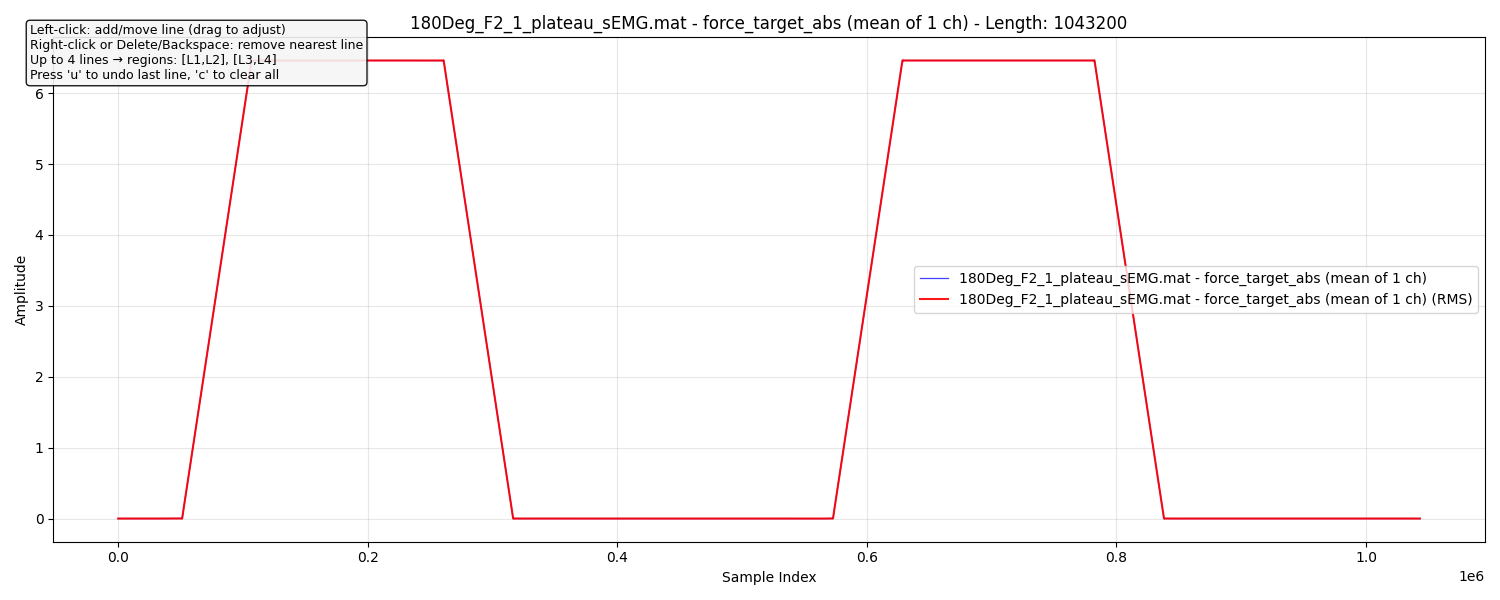

Added line at x=108956. Current lines: [108956]
Added line at x=261227. Current lines: [108956, 261227]
Added line at x=629883. Current lines: [108956, 261227, 629883]
Added line at x=782955. Current lines: [108956, 261227, 629883, 782955]


In [79]:
file_current = 'P5_Julia_sEMG/180Deg_F2_1_plateau_sEMG.mat'
selector, data = quick_plot(file_current,'force_target_abs') 

In [80]:
print(selector.get_lines())        # e.g., [120, 350, 800, 1200]
regions = selector.extract_regions(signal=data['EMG'])

[108956, 261227, 629883, 782955]


In [81]:
regions

[{'region_num': 1,
  'start_idx': 108956,
  'end_idx': 261227,
  'length': 152271,
  'data': array([[-0.00508626, -0.00508626, -0.00508626, ..., -0.00610352,
          -0.00661214, -0.00610352],
         [ 0.00915527,  0.01017253,  0.00508626, ...,  0.05391439,
           0.04882812,  0.04679362],
         [-0.00254313,  0.00050863, -0.00406901, ...,  0.0406901 ,
           0.03662109,  0.03356934],
         ...,
         [ 0.0213623 ,  0.03458659,  0.03560384, ...,  0.03509521,
           0.03560384,  0.03662109],
         [ 0.03611246,  0.04730225,  0.05137125, ...,  0.04882812,
           0.05238851,  0.05594889],
         [ 0.01271566,  0.0213623 ,  0.01831055, ...,  0.06306966,
           0.06561279,  0.06357829]], shape=(96, 152271), dtype=float32)},
 {'region_num': 2,
  'start_idx': 629883,
  'end_idx': 782955,
  'length': 153072,
  'data': array([[-0.00508626, -0.00508626, -0.00457764, ..., -0.00661214,
          -0.00661214, -0.00610352],
         [-0.06154378, -0.06052653, -0

In [82]:
import os

# Create the new folder if it doesn't exist
output_folder = "P5_prp_surfaceEMG"
os.makedirs(output_folder, exist_ok=True)
combined = {
        'data': data,
        'regions': regions,
    }

# -------------------------
# 4) Speichern als gemeinsames .npy
# -------------------------
out_path = 'P5_prp_surfaceEMG/180_F2_1_sEMG.npy'
np.save(out_path, combined, allow_pickle=True)
print("Gespeichert nach:", out_path)



Gespeichert nach: P5_prp_surfaceEMG/180_F2_1_sEMG.npy


In [83]:

semg = np.load(out_path, allow_pickle=True).item()

In [84]:
semg['data']['force_target_abs']


array([[-1.01252340e-14,  1.20478678e-07,  2.40951113e-07, ...,
        -3.61357483e-07, -2.40929700e-07, -1.20473339e-07]],
      shape=(1, 1043200))

(1043200,)


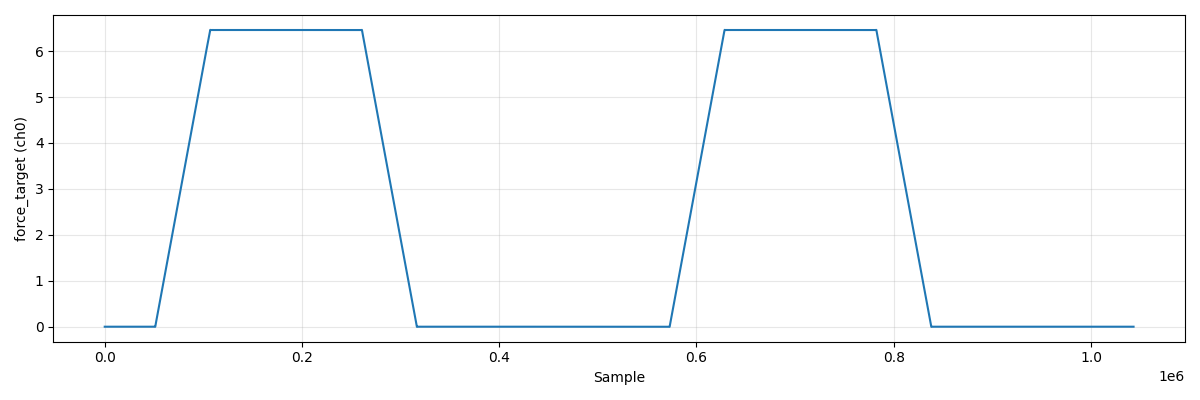

In [85]:
ft = semg['data']['force_target_abs'].squeeze()
print(ft.shape)

plt.figure(figsize=(12, 4))
plt.plot(ft)              # first row
plt.xlabel("Sample")
plt.ylabel("force_target (ch0)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

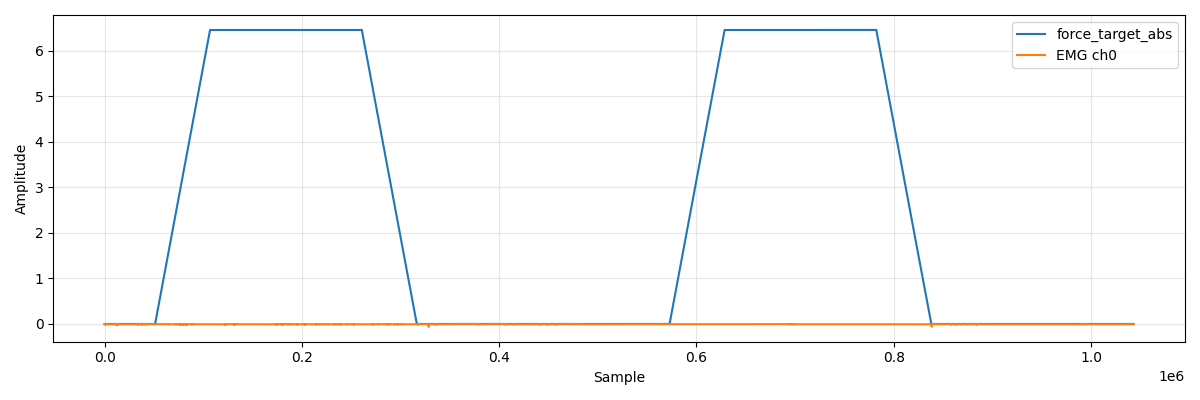

In [86]:
ft = semg['data']['force_target_abs'].squeeze()
EMG = np.asarray(semg['data']['EMG'])

plt.figure(figsize=(12, 4))
plt.plot(ft, label="force_target_abs")          # (T,)
plt.plot(EMG[0], label="EMG ch0")               # (T,) first channel
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


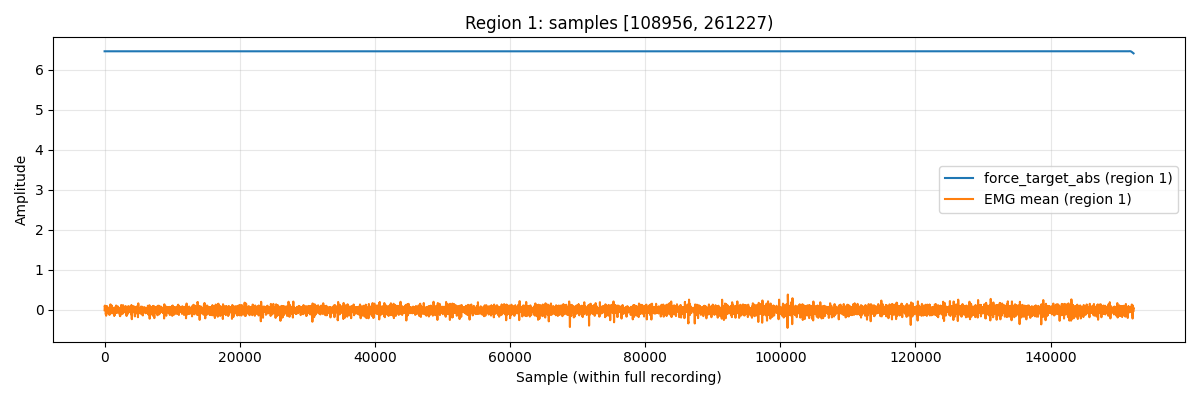

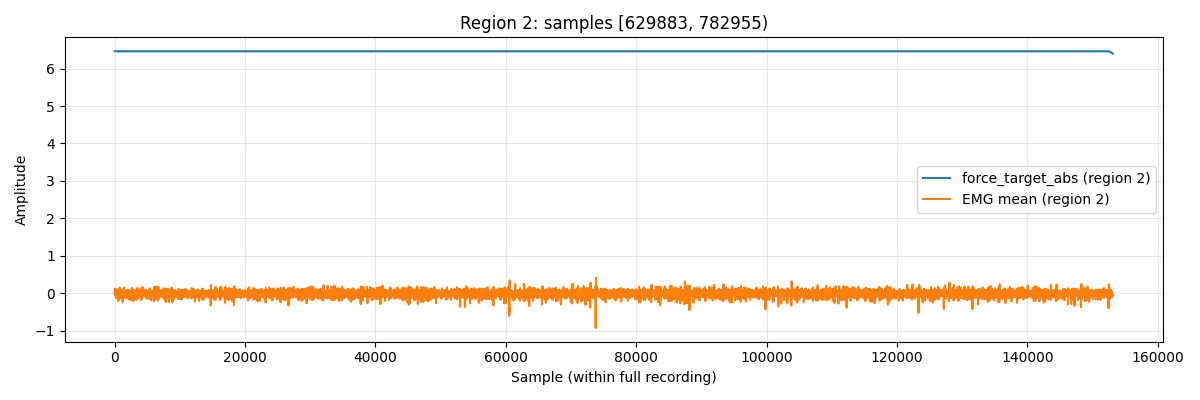

In [87]:
import numpy as np
import matplotlib.pyplot as plt

semg = np.load(out_path, allow_pickle=True).item()

ft = semg['data']['force_target_abs'].squeeze()
EMG = np.asarray(semg['data']['EMG'])
regions = semg['regions']   # old format: list of {'start_idx', 'end_idx', ...}

# Take mean EMG over channels for easier plotting
emg_mean = EMG.mean(axis=0)

# ---------- Region 1: regions[0] (lines 0–1) ----------
r1 = regions[0]
s1, e1 = r1['start_idx'], r1['end_idx']

plt.figure(figsize=(12, 4))
plt.plot(ft[s1:e1], label="force_target_abs (region 1)")
plt.plot(emg_mean[s1:e1], label="EMG mean (region 1)")
plt.xlabel("Sample (within full recording)")
plt.ylabel("Amplitude")
plt.title(f"Region 1: samples [{s1}, {e1})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Region 2: regions[1] (lines 2–3) ----------
r2 = regions[1]
s2, e2 = r2['start_idx'], r2['end_idx']

plt.figure(figsize=(12, 4))
plt.plot(ft[s2:e2], label="force_target_abs (region 2)")
plt.plot(emg_mean[s2:e2], label="EMG mean (region 2)")
plt.xlabel("Sample (within full recording)")
plt.ylabel("Amplitude")
plt.title(f"Region 2: samples [{s2}, {e2})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [88]:
import numpy as np
from copy import deepcopy

# -------- load old structure --------
old_path = out_path
semg_old = np.load(old_path, allow_pickle=True).item()

data_inner = semg_old["data"]          # dict with EMG, force_*, fsamp, ...
regions    = semg_old.get("regions", [])  # list of {'region_num', 'start_idx', 'end_idx', 'length', 'data'}

print("Inner keys:", data_inner.keys())
print("Num regions:", len(regions))

# -------- 1) lift inner data keys to top level (no numeric changes) --------
new = {}

for k, v in data_inner.items():
    # optionally skip MATLAB meta
    if k in ("__header__", "__version__", "__globals__"):
        continue
    new[k] = v

# -------- 2) build cuts from regions (metadata only) --------
cuts = []
if regions:
    # sort regions by start_idx just to be explicit
    regs_sorted = sorted(regions, key=lambda r: r["start_idx"])

    # sampling frequency from fsamp (unchanged)
    fsamp = float(np.asarray(data_inner["fsamp"]).astype(float).ravel()[0])

    # first region -> idx01, t0/t1
    r1 = regs_sorted[0]
    s1, e1 = int(r1["start_idx"]), int(r1["end_idx"])
    idx01 = np.array([s1, e1], dtype=int)
    t0 = s1 / fsamp
    t1 = e1 / fsamp

    # optional second region -> idx23, t2/t3
    if len(regs_sorted) > 1:
        r2 = regs_sorted[1]
        s2, e2 = int(r2["start_idx"]), int(r2["end_idx"])
        idx23 = np.array([s2, e2], dtype=int)
        t2 = s2 / fsamp
        t3 = e2 / fsamp
        indices_all = np.concatenate([idx01, idx23])
    else:
        idx23 = np.array([], dtype=int)
        t2 = np.nan
        t3 = np.nan
        indices_all = idx01.copy()

    cut = {
        "idx01": idx01,
        "idx23": idx23,
        "indices_all": indices_all,
        "t0": t0,
        "t1": t1,
        "t2": t2,
        "t3": t3,
        "fs_est": fsamp,
        "kind": "plateau",   # default label
    }
    cuts.append(cut)

new["cuts"] = cuts

# -------- 3) keep original nested data & regions for safety --------
new["data"] = data_inner                # original nested dict, unchanged
new["regions_legacy"] = deepcopy(regions)   # original region dicts incl. 'data' slices

# -------- 4) save to new file with combined-style structure --------
out_path = "P5_prp_surfaceEMG/180Deg_F2_1_sEMG.npy"
np.save(out_path, new, allow_pickle=True)

print(f"Saved restructured file to: {out_path}")
print("New top-level keys:", new.keys())
if cuts:
    print("Example cut entry:", cuts[0])


Inner keys: dict_keys(['__header__', '__version__', '__globals__', 'EMG', 'ForceAmplitude', 'Force_Direction', 'Force_N_Conversion_Factor', 'MCP_Angle', 'MVC_Value', 'Protocol_Series', 'Slope_Down', 'Slope_Up', 'file', 'filename', 'files', 'force_conv', 'force_conv_abs', 'force_raw', 'force_raw_abs', 'force_target', 'force_target_abs', 'fsamp', 'timestamps'])
Num regions: 2
Saved restructured file to: P5_prp_surfaceEMG/180Deg_F2_1_sEMG.npy
New top-level keys: dict_keys(['EMG', 'ForceAmplitude', 'Force_Direction', 'Force_N_Conversion_Factor', 'MCP_Angle', 'MVC_Value', 'Protocol_Series', 'Slope_Down', 'Slope_Up', 'file', 'filename', 'files', 'force_conv', 'force_conv_abs', 'force_raw', 'force_raw_abs', 'force_target', 'force_target_abs', 'fsamp', 'timestamps', 'cuts', 'data', 'regions_legacy'])
Example cut entry: {'idx01': array([108956, 261227]), 'idx23': array([629883, 782955]), 'indices_all': array([108956, 261227, 629883, 782955]), 't0': 10.640234375, 't1': 25.51044921875, 't2': 61.5

ft shape: (1043200,)
EMG shape: (96, 1043200)


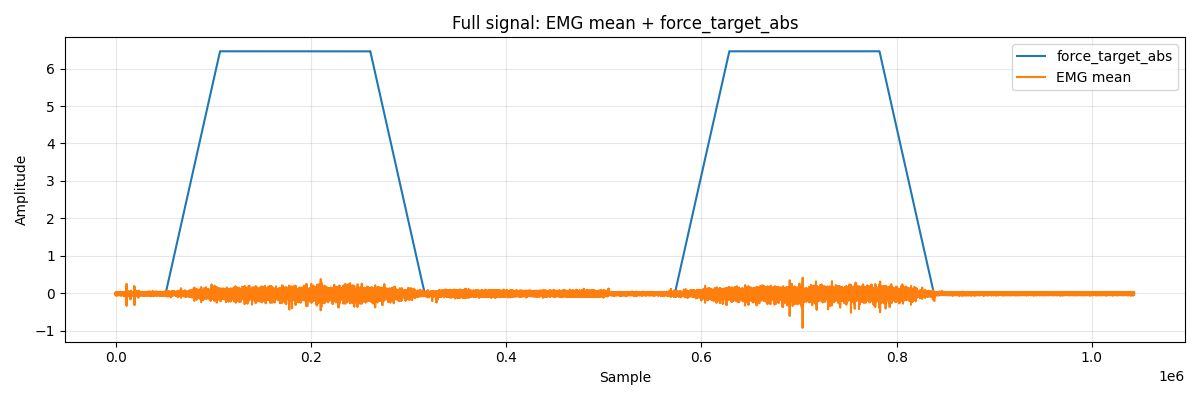

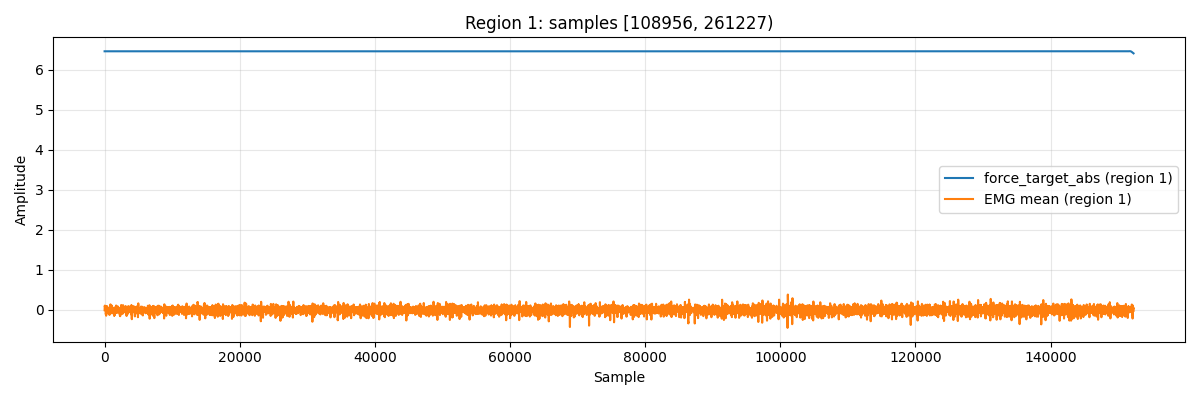

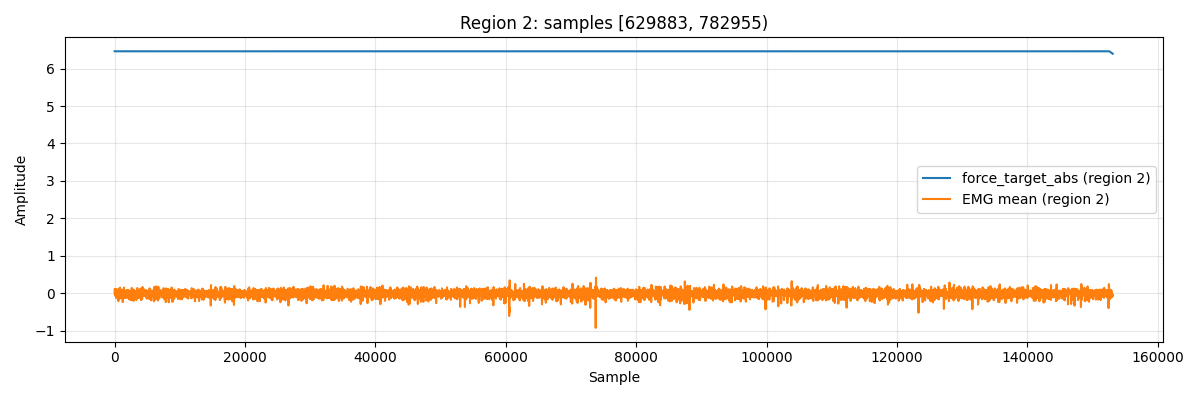

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- load new file ----------
semg = np.load(out_path, allow_pickle=True).item()

# top-level keys now
ft = np.asarray(semg['force_target_abs']).squeeze()   # (T,)
EMG = np.asarray(semg['EMG'])                         # (C, T)
cuts = semg['cuts']                                   # list, we packed both regions into cuts[0]

emg_mean = EMG.mean(axis=0)                           # (T,)

print("ft shape:", ft.shape)
print("EMG shape:", EMG.shape)

# ---------- 1) Full plot ----------
plt.figure(figsize=(12, 4))
plt.plot(ft, label="force_target_abs")
plt.plot(emg_mean, label="EMG mean")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Full signal: EMG mean + force_target_abs")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 2) Region 1: idx01 (lines 0–1) ----------
cut0 = cuts[0]
idx01 = cut0["idx01"]          # [start, end] for first segment
start1, end1 = int(idx01[0]), int(idx01[1])

plt.figure(figsize=(12, 4))
plt.plot(ft[start1:end1], label="force_target_abs (region 1)")
plt.plot(emg_mean[start1:end1], label="EMG mean (region 1)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title(f"Region 1: samples [{start1}, {end1})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 3) Region 2: idx23 (lines 2–3) ----------
idx23 = cut0["idx23"]          # [] or [start2, end2]
if idx23.size == 2:
    start2, end2 = int(idx23[0]), int(idx23[1])

    plt.figure(figsize=(12, 4))
    plt.plot(ft[start2:end2], label="force_target_abs (region 2)")
    plt.plot(emg_mean[start2:end2], label="EMG mean (region 2)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(f"Region 2: samples [{start2}, {end2})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No second region stored in idx23.")


# Integrating surface EMG

In [12]:
# === USER CONFIG ===
NPY_PATH      = "P3_combined/90Deg_F1_1_combined.npy"  # <- change to your new npy file
MAT_PATH      = 'P3_Julia_sEMG/90Deg_F1_1_plateau_sEMG.mat'  # <- change to your old mat file
SIG_KEY_NPY   = "EMG"                  # key/name for SIG in the npy file (if dict-like)
EMG_KEY_MAT   = "EMG"                  # key name for EMG in the mat file


In [13]:
import numpy as np

print("=== NPY FILE INSPECTION ===")
npy_obj = np.load(NPY_PATH, allow_pickle=True)
print(f"Type: {type(npy_obj)}, dtype: {getattr(npy_obj, 'dtype', None)}, shape: {getattr(npy_obj, 'shape', None)}")

if isinstance(npy_obj, dict):
    print("NPY is a dict. Keys:")
    for k, v in npy_obj.items():
        print(f"  {k:20s} -> type={type(v)}, shape={getattr(v, 'shape', None)}")
elif isinstance(npy_obj, np.ndarray) and npy_obj.dtype == object and npy_obj.shape == ():
    inner = npy_obj.item()
    print("NPY is 0-dim object array")
    print("  Inner type:", type(inner))
    if isinstance(inner, dict):
        print("  Inner is dict with keys:")
        for k, v in inner.items():
            print(f"    {k:20s} -> type={type(v)}, shape={getattr(v, 'shape', None)}")
    else:
        print("  Inner is not a dict; no keys to show.")
else:
    print("NPY is treated as a plain array (no dict keys).")
    print("  Sample values:", np.asarray(npy_obj).flatten()[:5])

print("\n=== MAT FILE INSPECTION ===")
mat_data = load_mat_file(MAT_PATH)   # uses your helper
if mat_data is not None:
    for k, v in mat_data.items():
        if k.startswith("__"):
            continue
        print(f"  {k:20s} -> type={type(v)}, shape={getattr(v, 'shape', None)}, dtype={getattr(v, 'dtype', None)}")


=== NPY FILE INSPECTION ===
Type: <class 'numpy.ndarray'>, dtype: object, shape: ()
NPY is 0-dim object array
  Inner type: <class 'dict'>
  Inner is dict with keys:
    time_s               -> type=<class 'numpy.ndarray'>, shape=(529997,)
    Fx                   -> type=<class 'numpy.ndarray'>, shape=(529997,)
    Fy                   -> type=<class 'numpy.ndarray'>, shape=(529997,)
    Fab                  -> type=<class 'numpy.ndarray'>, shape=(529997,)
    force_target         -> type=<class 'numpy.ndarray'>, shape=(2, 529997)
    force_target_abs     -> type=<class 'numpy.ndarray'>, shape=(529997,)
    MCP_Angle            -> type=<class 'int'>, shape=None
    Force_Direction      -> type=<class 'int'>, shape=None
    force_aligned        -> type=<class 'dict'>, shape=None
    EMG                  -> type=<class 'numpy.ndarray'>, shape=(16, 529997)
    emg_aligned_extras   -> type=<class 'dict'>, shape=None
    ref_signal           -> type=<class 'numpy.ndarray'>, shape=(529997,)

In [15]:
mat_data['fsamp']

array([[10240]], dtype=int32)

In [ ]:

import numpy as np

def _extract_sig_from_npy(npy_path, sig_key="SIG"):
    """
    Try to load SIG from a .npy file that may store:
    - a plain array (then we treat the whole array as SIG)
    - a dict (np.save of a dict)
    - a 0-dim object array containing a dict (np.save on a dict, then .item()).
    """
    arr = np.load(npy_path, allow_pickle=True)
    print(f"Loaded NPY type: {type(arr)}, dtype: {getattr(arr, 'dtype', None)}, shape: {getattr(arr, 'shape', None)}")

    # Case 1: directly a dict
    if isinstance(arr, dict):
        if sig_key not in arr:
            raise KeyError(f"Key '{sig_key}' not found in NPY dict.")
        print(f"Using dict entry '{sig_key}' from NPY.")
        return arr[sig_key]

    # Case 2: object array that wraps a dict (common with np.save on dict)
    if isinstance(arr, np.ndarray) and arr.dtype == object and arr.shape == ():
        inner = arr.item()
        if not isinstance(inner, dict):
            print("0-dim object array, but inner is not a dict; using inner as SIG.")
            return inner
        if sig_key not in inner:
            raise KeyError(f"Key '{sig_key}' not found in inner dict in NPY.")
        print(f"Using inner dict entry '{sig_key}' from NPY.")
        return inner[sig_key]

    # Case 3: any other array -> assume it's already the SIG array
    print("NPY is treated as SIG array directly (no dict key lookup).")
    return arr


def channel_lengths(signal):
    """
    Return a list of per-channel time lengths (no truncation).
    
    - If numeric 1D -> [len(signal)]
    - If numeric 2D -> shape (C, T) -> [T, T, ..., T]
    - If object array (cell-like) -> each non-empty cell is one channel,
      length = number of finite samples in that cell's 1D data.
    """
    # Object / cell array case
    if isinstance(signal, np.ndarray) and signal.dtype == object:
        lens = []
        flat = signal.ravel()
        for i, elem in enumerate(flat):
            arr = np.asarray(elem).squeeze()
            if arr.ndim > 1:
                arr = arr.reshape(-1)
            arr = arr[np.isfinite(arr)]
            if arr.size > 0:
                lens.append(len(arr))
            else:
                print(f"Channel {i}: empty or non-finite, ignored in length summary.")
        return lens

    # Numeric arrays
    sig = np.asarray(signal, dtype=float)
    sig = sig[np.isfinite(sig)] if sig.ndim == 1 else sig

    if sig.ndim == 1:
        return [len(sig)]
    elif sig.ndim == 2:
        # assume (channels, time)
        C, T = sig.shape
        return [T] * C
    else:
        # Fallback: treat axis 0 as channels, flatten all others as time
        C = sig.shape[0]
        T = int(np.prod(sig.shape[1:]))
        return [T] * C


def summarize_lengths(name, lengths):
    if not lengths:
        print(f"{name}: No valid channels found.")
        return None
    min_len = min(lengths)
    max_len = max(lengths)
    print(f"{name}:")
    print(f"  #channels        : {len(lengths)}")
    print(f"  min length       : {min_len}")
    print(f"  max length       : {max_len}")
    print(f"  all equal?       : {min_len == max_len}")
    if len(lengths) <= 16:
        print(f"  per-channel lens : {lengths}")
    else:
        print(f"  first 8 lengths  : {lengths[:8]}")
        print(f"  last  8 lengths  : {lengths[-8:]}")
    return min_len, max_len


# === Load SIG from NPY ===
print(f"=== Loading SIG from NPY: {NPY_PATH} ===")
sig_raw = _extract_sig_from_npy(NPY_PATH, sig_key=SIG_KEY_NPY)
sig_lengths = channel_lengths(sig_raw)
sig_min, sig_max = summarize_lengths("SIG (NPY)", sig_lengths) if sig_lengths else (None, None)

# === Load EMG from MAT using your existing helper ===
print(f"\n=== Loading EMG from MAT: {MAT_PATH} ===")
mat_data = load_mat_file(MAT_PATH)
if mat_data is None:
    raise RuntimeError("Failed to load MAT file.")

if EMG_KEY_MAT not in mat_data:
    raise KeyError(f"EMG key '{EMG_KEY_MAT}' not found in MAT file. Available keys: {list(mat_data.keys())}")

emg_raw = mat_data[EMG_KEY_MAT]
emg_lengths = channel_lengths(emg_raw)
emg_min, emg_max = summarize_lengths("EMG (MAT)", emg_lengths) if emg_lengths else (None, None)

# === Cross comparison of *per-channel* time length between SIG and EMG ===
print("\n=== Cross-file check (timepoints per channel) ===")
if sig_min is not None and emg_min is not None:
    # we use the nominal time length for each file as "the" channel length
    # (only meaningful if all_equal is True in both cases)
    print(f"Nominal SIG length per channel : {sig_min} (assuming all equal in SIG)")
    print(f"Nominal EMG length per channel : {emg_min} (assuming all equal in EMG)")
    print(f"Same length? {sig_min == emg_min}")
else:
    print("Could not compute nominal channel lengths for one or both files.")


=== Loading SIG from NPY: P3_combined/90Deg_F1_1_combined.npy ===
Loaded NPY type: <class 'numpy.ndarray'>, dtype: object, shape: ()
Using inner dict entry 'EMG' from NPY.
SIG (NPY):
  #channels        : 16
  min length       : 529997
  max length       : 529997
  all equal?       : True
  per-channel lens : [529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997, 529997]

=== Loading EMG from MAT: P3_Julia_sEMG/90Deg_F1_1_plateau_sEMG.mat ===
Loaded non-v7.3 file: P3_Julia_sEMG/90Deg_F1_1_plateau_sEMG.mat
EMG (MAT):
  #channels        : 96
  min length       : 921600
  max length       : 921600
  all equal?       : True
  first 8 lengths  : [921600, 921600, 921600, 921600, 921600, 921600, 921600, 921600]
  last  8 lengths  : [921600, 921600, 921600, 921600, 921600, 921600, 921600, 921600]

=== Cross-file check (timepoints per channel) ===
Nominal SIG length per channel : 529997 (assuming all equal in SIG)
Nominal EMG leng

SIG channel length: 529997 samples
EMG channel length: 921600 samples


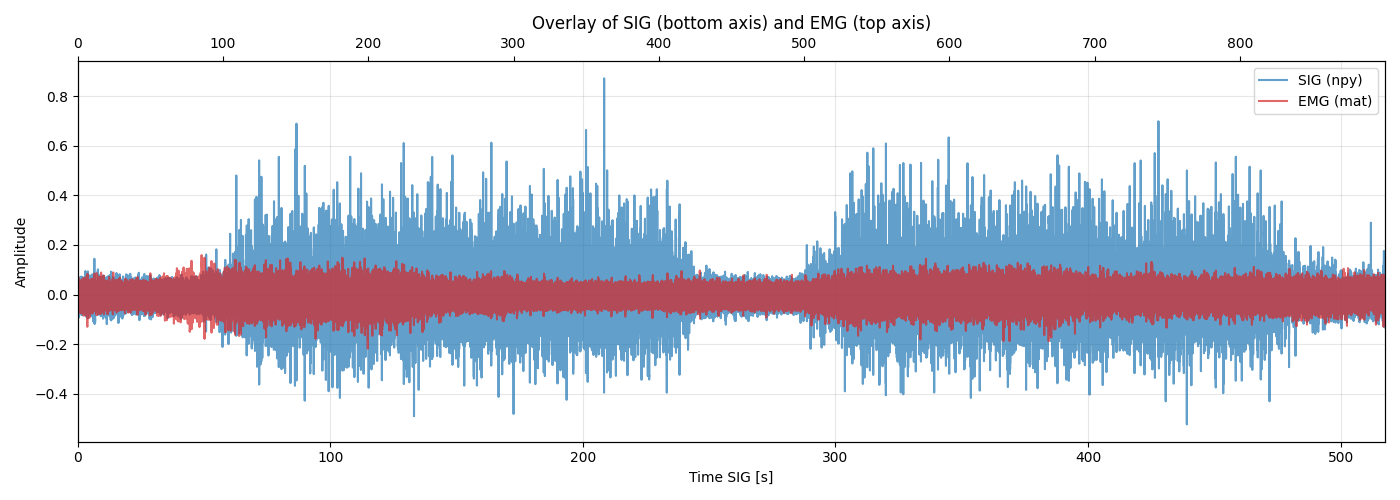

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === USER CONFIG ===
SIG_CH_IDX = 0      # which SIG channel to plot (0-based)
EMG_CH_IDX = 0      # which EMG channel to plot (0-based)
FS_SIG = 1024.0     # sampling rate for SIG (Hz) - adjust if needed
FS_EMG = 1024.0     # sampling rate for EMG (Hz) - adjust if needed

def get_channel_1d(signal, ch_idx=0):
    """
    Extract a single 1D channel from potentially weird formats:
    - 1D numeric  -> returns as is (ignores ch_idx)
    - 2D numeric  -> (channels, time), returns signal[ch_idx]
    - object array (MATLAB cell-like) -> uses flat[ch_idx] as one channel
    """
    # Object / cell array
    if isinstance(signal, np.ndarray) and signal.dtype == object:
        flat = signal.ravel()
        if ch_idx >= len(flat):
            raise IndexError(f"Requested channel {ch_idx}, but only {len(flat)} entries in object array.")
        arr = np.asarray(flat[ch_idx]).squeeze()
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        arr = arr.astype(float)
        arr = arr[np.isfinite(arr)]
        return arr

    # Numeric arrays
    s = np.asarray(signal, dtype=float)
    s = s[np.isfinite(s)] if s.ndim == 1 else s

    if s.ndim == 1:
        return s
    elif s.ndim == 2:
        if ch_idx >= s.shape[0]:
            raise IndexError(f"Requested channel {ch_idx}, but only {s.shape[0]} channels.")
        return s[ch_idx]
    else:
        # Fallback: treat axis 0 as channels, flatten all others as time
        if ch_idx >= s.shape[0]:
            raise IndexError(f"Requested channel {ch_idx}, but only {s.shape[0]} channels.")
        arr = s[ch_idx]
        return arr.reshape(-1)

# --- Extract one channel from each ---

sig_ch = get_channel_1d(sig_raw, ch_idx=SIG_CH_IDX)
emg_ch = get_channel_1d(emg_raw, ch_idx=EMG_CH_IDX)

print(f"SIG channel length: {len(sig_ch)} samples")
print(f"EMG channel length: {len(emg_ch)} samples")

# --- Build separate time axes ---

t_sig = np.arange(len(sig_ch)) / FS_SIG
t_emg = np.arange(len(emg_ch)) / FS_EMG

# --- Plot with two x-axes (bottom: SIG, top: EMG) ---

fig, ax_sig = plt.subplots(figsize=(14, 5))

# Primary axis: SIG
ax_sig.plot(t_sig, sig_ch, label="SIG (npy)", alpha=0.7)
ax_sig.set_xlabel("Time SIG [s]")
ax_sig.set_ylabel("Amplitude")
ax_sig.set_title("Overlay of SIG (bottom axis) and EMG (top axis)")

# Secondary x-axis: EMG
ax_emg = ax_sig.twiny()
ax_emg.plot(t_emg, emg_ch, color="tab:red", alpha=0.7, label="EMG (mat)")

# Make axes share the same physical width but different x-limits
ax_sig.set_xlim(t_sig[0], t_sig[-1])
ax_emg.set_xlim(t_emg[0], t_emg[-1])

# Legends: combine both
lines_sig, labels_sig = ax_sig.get_legend_handles_labels()
lines_emg, labels_emg = ax_emg.get_legend_handles_labels()
ax_sig.legend(lines_sig + lines_emg, labels_sig + labels_emg, loc="upper right")

ax_sig.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== Lade force_target aus NPY ===
NPY geladen: type=<class 'numpy.ndarray'>, dtype=object, shape=()
NPY ist 0-dim object, inner type=<class 'dict'>
Nutze inner['force_target']

=== Lade force_target aus MAT ===
Loaded non-v7.3 file: P3_Julia_sEMG/90Deg_F1_1_plateau_sEMG.mat

force_target (NPY) Länge: 529997 Samples
force_target (MAT) Länge: 921600 Samples


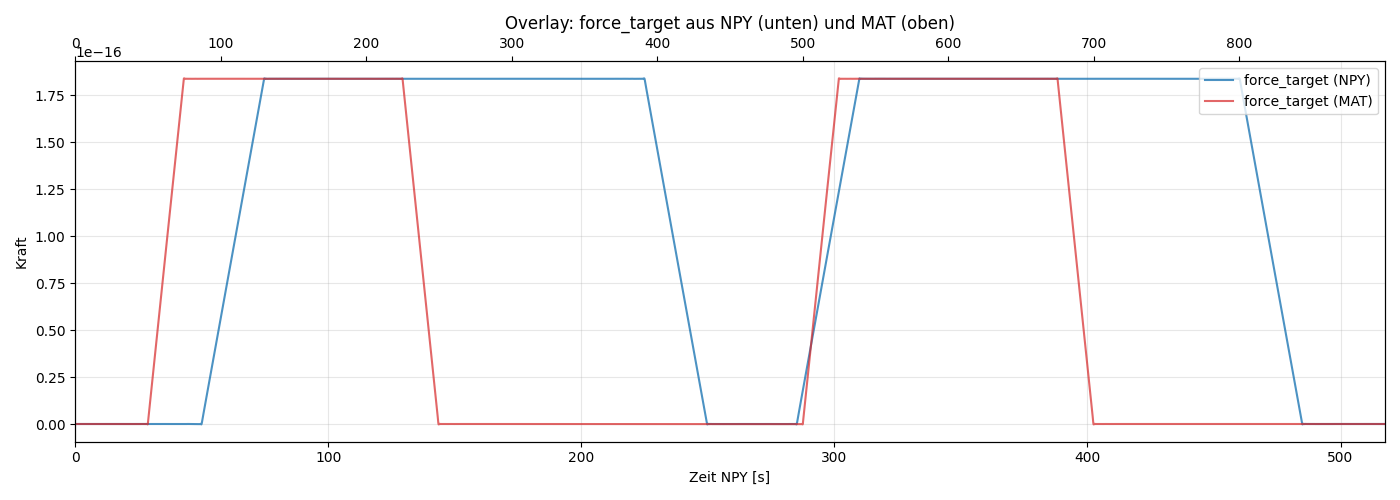

In [14]:


FORCE_KEY_NPY   = "force_target"            # Key in der .npy-Datei
FORCE_KEY_MAT   = "force_target"            # Key in der .mat-Datei

FORCE_COMP_IDX  = 0     # falls force_target 2D ist: welche Komponente (z.B. 0=Fx, 1=Fy)
FS_NPY          = 1024.0  # Samplingrate für NPY-Force (Hz) – anpassen falls bekannt
FS_MAT          = 1024.0  # Samplingrate für MAT-Force (Hz) – anpassen falls bekannt

import numpy as np
import matplotlib.pyplot as plt

# --- Hilfsfunktionen ---

def _extract_key_from_npy(npy_path, key):
    """
    Lädt eine .npy-Datei und versucht, `key` daraus zu holen.
    Unterstützt:
      - dict direkt
      - 0-dim object array mit dict innen
      - plain array (dann wird das gesamte Array verwendet)
    """
    arr = np.load(npy_path, allow_pickle=True)
    print(f"NPY geladen: type={type(arr)}, dtype={getattr(arr, 'dtype', None)}, shape={getattr(arr, 'shape', None)}")

    # Fall 1: direkt ein dict
    if isinstance(arr, dict):
        if key not in arr:
            raise KeyError(f"Key '{key}' nicht in NPY-dict. Verfügbare Keys: {list(arr.keys())}")
        print(f"Nutze NPY['{key}']")
        return arr[key]

    # Fall 2: 0-dim object array mit dict innen
    if isinstance(arr, np.ndarray) and arr.dtype == object and arr.shape == ():
        inner = arr.item()
        print(f"NPY ist 0-dim object, inner type={type(inner)}")
        if isinstance(inner, dict):
            if key not in inner:
                raise KeyError(f"Key '{key}' nicht im inneren dict. Verfügbare Keys: {list(inner.keys())}")
            print(f"Nutze inner['{key}']")
            return inner[key]
        # kein dict → nimm inner komplett
        print("Inner ist kein dict, verwende inner direkt als force_target.")
        return inner

    # Fall 3: alles andere → komplettes Array ist force_target
    print("NPY wird als plain Array verwendet (kein dict-key lookup).")
    return arr


def get_force_1d(force_arr, comp_idx=0):
    """
    Extrahiert eine 1D-Kurve aus force_target:
      - 1D numeric         -> direkt zurück
      - 2D numeric (C,T)   -> nimmt Zeile comp_idx (z.B. Komponente/Channel)
      - Objekt-Array       -> nimmt Eintrag comp_idx und flatten
    """
    # Objekt-Array (MATLAB-cell-like)
    if isinstance(force_arr, np.ndarray) and force_arr.dtype == object:
        flat = force_arr.ravel()
        if comp_idx >= len(flat):
            raise IndexError(f"FORCE_COMP_IDX={comp_idx}, aber nur {len(flat)} Einträge im object-array.")
        arr = np.asarray(flat[comp_idx]).squeeze()
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        arr = arr.astype(float)
        arr = arr[np.isfinite(arr)]
        return arr

    # Numerisch
    f = np.asarray(force_arr, dtype=float)

    if f.ndim == 1:
        return f[np.isfinite(f)]

    if f.ndim == 2:
        if comp_idx >= f.shape[0]:
            raise IndexError(f"FORCE_COMP_IDX={comp_idx}, aber nur {f.shape[0]} Reihen (Kanäle/Komponenten).")
        row = f[comp_idx]
        return row[np.isfinite(row)]

    # Fallback: behandle Achse 0 als Komponenten, rest flatten
    if comp_idx >= f.shape[0]:
        raise IndexError(f"FORCE_COMP_IDX={comp_idx}, aber nur {f.shape[0]} Komponenten.")
    row = f[comp_idx].reshape(-1)
    return row[np.isfinite(row)]


# === 1. force_target aus beiden Dateien laden ===

print("=== Lade force_target aus NPY ===")
force_npy_raw = _extract_key_from_npy(NPY_PATH, FORCE_KEY_NPY)

print("\n=== Lade force_target aus MAT ===")
mat_data = load_mat_file(MAT_PATH)   # nutzt deine vorhandene Funktion
if mat_data is None:
    raise RuntimeError("MAT-Datei konnte nicht geladen werden.")

if FORCE_KEY_MAT not in mat_data:
    raise KeyError(
        f"Key '{FORCE_KEY_MAT}' nicht in MAT-Datei gefunden. "
        f"Verfügbare Keys: {[k for k in mat_data.keys() if not k.startswith('__')]}"
    )
force_mat_raw = mat_data[FORCE_KEY_MAT]

# === 2. 1D-Kurve aus beiden force_target-Arrays ziehen ===

force_npy = get_force_1d(force_npy_raw, comp_idx=FORCE_COMP_IDX)
force_mat = get_force_1d(force_mat_raw, comp_idx=FORCE_COMP_IDX)

print(f"\nforce_target (NPY) Länge: {len(force_npy)} Samples")
print(f"force_target (MAT) Länge: {len(force_mat)} Samples")

t_npy = np.arange(len(force_npy)) / FS_NPY
t_mat = np.arange(len(force_mat)) / FS_MAT

# === 3. Overlay-Plot mit zwei x-Achsen ===

fig, ax_npy = plt.subplots(figsize=(14, 5))

# Untere Achse: NPY-force_target
ax_npy.plot(t_npy, force_npy, label="force_target (NPY)", alpha=0.8)
ax_npy.set_xlabel("Zeit NPY [s]")
ax_npy.set_ylabel("Kraft")
ax_npy.set_title("Overlay: force_target aus NPY (unten) und MAT (oben)")

# Obere Achse: MAT-force_target
ax_mat = ax_npy.twiny()
ax_mat.plot(t_mat, force_mat, color="tab:red", alpha=0.7, label="force_target (MAT)")

# Achsen-Limits
ax_npy.set_xlim(t_npy[0], t_npy[-1])
ax_mat.set_xlim(t_mat[0], t_mat[-1])

# Gemeinsame Legende
lines_npy, labels_npy = ax_npy.get_legend_handles_labels()
lines_mat, labels_mat = ax_mat.get_legend_handles_labels()
ax_npy.legend(lines_npy + lines_mat, labels_npy + labels_mat, loc="upper right")

ax_npy.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
